# Frequency Transform

In this tutorial we will practice Fourier transform of Numpy arrays using the Scipy FFTpack module. We will practice on the UW seismic station that is located in SoDo next to the freight train station.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data prep
we download the data and perform a minimal pre-processing (detrend, demean)

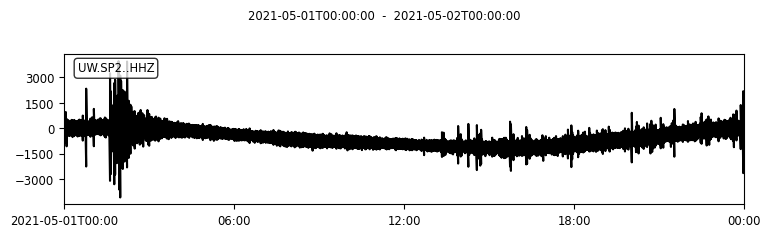

In [2]:
# Import the Obspy modules that will be useful to download seismic data
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime

# Solution
network = 'UW'
station = 'SP2'
channel = 'HHZ'# this channel gives a low frequency, 1Hz signal.
Tstart = UTCDateTime(year=2021, month=5, day=1)
Tend = UTCDateTime(year=2021, month=5, day=2)
fdsn_client = fdsn.Client('IRIS')
Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, \
    endtime=Tend, attach_response=True)
Z.detrend()
Z.merge()
Z.plot()
T = np.linspace(0,(Tend-Tstart),Z[0].stats.npts)


## 2. Fourier transform
We will use the real Fourier transform because all of the time series we will work with are real values.
You can find information here:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.rfft.html#scipy.fftpack.rfft

In [3]:
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

npts = Z[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(Z[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Zhat = fft(Z[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)


Plot the amplitude and phase spectra

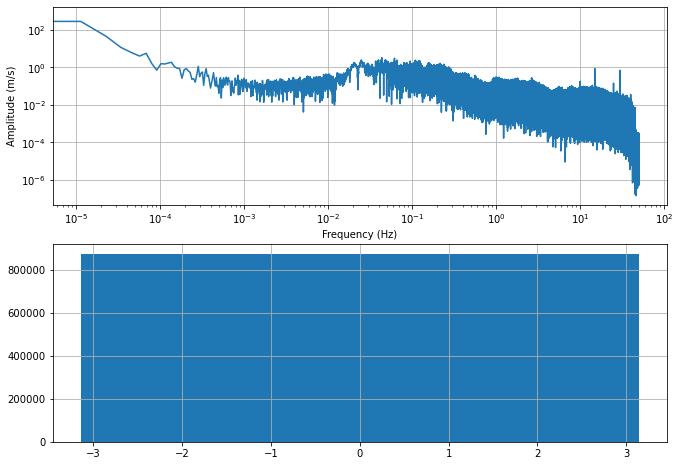

In [4]:
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.angle(Zhat))
ax[1].grid(True)


You will note above that the phase values are randomly distributed between -pi and pi.

# create synthetic noise

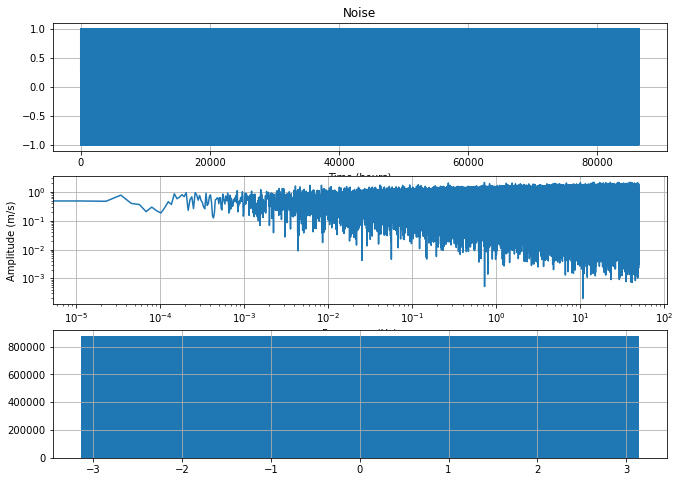

In [5]:
from numpy import random

# random values in time domain
noise=2*random.rand(npts)-1


## FFT the signals
# fill up until 2^N value to speed up the FFT
Zhat = fft(noise,n=Nfft)#/   fg g           gnp.sqrt(Z[0].stats.npts)
fig,ax=plt.subplots(3,1,figsize=(11,8))
ax[0].plot(T,noise)
# ax[0].set_xlim(0,24)
ax[0].grid(True)
ax[0].set_xlabel('Time (hours)')
ax[0].set_title('Noise')
ax[1].plot(freqVec,np.abs(Zhat[:Nfft//2])/np.sqrt(Nfft))
ax[1].grid(True)
ax[1].set_xscale('log');ax[1].set_yscale('log')
ax[1].set_xlabel('Frequency (Hz)');ax[1].set_ylabel('Amplitude (m/s)')
ax[2].hist(np.angle(Zhat))
ax[2].grid(True)
# random values in spectral domain, with a white spectrum



/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


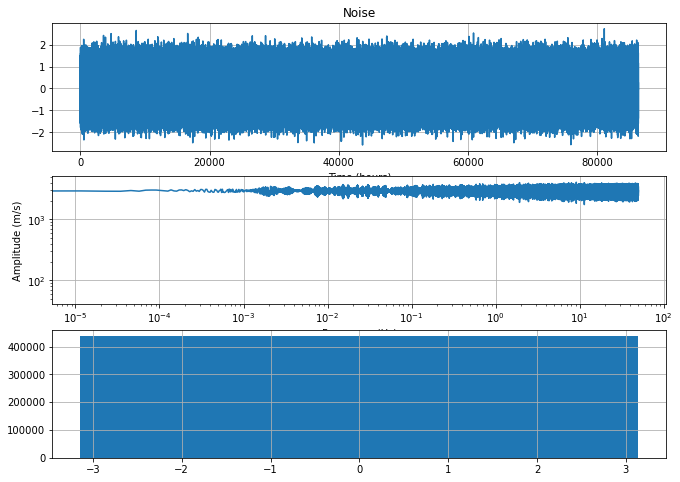

In [6]:
#Now create a noise window with a WHITE spectrum (flat) and a random phase

noisep = np.zeros(Nfft,dtype=complex)
noise = np.zeros(Nfft)
for i in range(1,Nfft//2):
    c=2*random.rand(1)-1
    noisep[i]=  np.exp(1j*np.pi*c[0])
noisep[Nfft//2:] = np.conj(noisep[:Nfft//2-1:-1])
noise = ifft(noisep)[:npts]*np.sqrt(Nfft)
# trim back to the length of the original time series
# noise = noise*np.sqrt(Nfft)



Zhat = fft(noise,n=Nfft)#/np.sqrt(Z[0].stats.npts)
fig,ax=plt.subplots(3,1,figsize=(11,8))
ax[0].plot(T,noise)
# ax[0].set_xlim(0,24);
ax[0].grid(True)
ax[0].set_xlabel('Time (hours)')
ax[0].set_title('Noise')
ax[1].plot(freqVec,np.abs(Zhat[:Nfft//2]))
ax[1].grid(True)
ax[1].set_xscale('log');ax[1].set_yscale('log')
ax[1].set_xlabel('Frequency (Hz)');ax[1].set_ylabel('Amplitude (m/s)')
ax[2].hist(np.angle(Zhat[:Nfft//2]))
ax[2].grid(True)



/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Amplitude (m/s)')

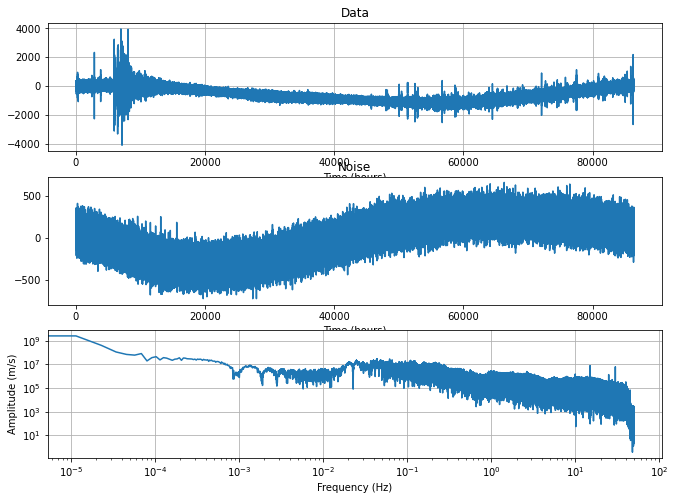

In [7]:
# Now use the spectrum from the real data, and impose a random phase
Zhat = fft(Z[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)
noisep = np.zeros(Nfft,dtype=complex)
noise = np.zeros(Nfft)
for i in range(1,Nfft//2):
    c=2*random.rand(1)-1
    noisep[i]=np.abs(Zhat[i])* np.exp(1j*np.pi*c[0])
noisep[Nfft//2:] = np.conj(noisep[:Nfft//2-1:-1])
noise = ifft(noisep)[:npts]#*np.sqrt(Nfft)
# trim back to the length of the original time series


Zhat = fft(noise,n=Nfft)#/np.sqrt(Z[0].stats.npts)
fig,ax=plt.subplots(3,1,figsize=(11,8))
ax[0].plot(T,Z[0].data)
# ax[0].set_xlim(0,24)
ax[0].grid(True)
ax[0].set_xlabel('Time (hours)')
ax[0].set_title('Data')

ax[1].plot(T,noise)
ax[1].set_xlabel('Time (hours)')
ax[1].set_title('Noise')
ax[2].plot(freqVec,np.abs(Zhat[:Nfft//2]))
ax[2].grid(True)
ax[2].set_xscale('log');ax[2].set_yscale('log')
ax[2].set_xlabel('Frequency (Hz)');ax[2].set_ylabel('Amplitude (m/s)')

## Spectrograms

2906.69580085


/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


561.938950322


(0.01, 0.5)

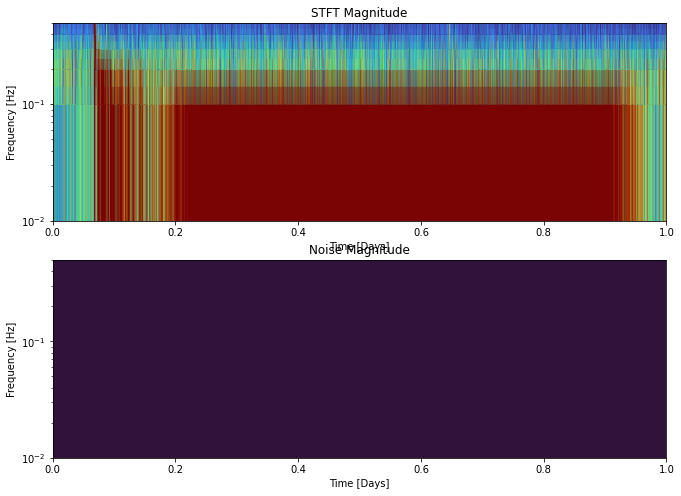

In [8]:
from scipy.signal import stft

nperseg=1000
f, t, Zxx = stft(Z[0].data, fs=100, nperseg=nperseg,noverlap=20)
print(np.max(np.max(np.abs(Zxx))))
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].pcolormesh(t/86400, f, np.abs(Zxx), vmin=0.1, vmax=1E2, shading='gouraud',cmap='turbo')
ax[0].set_title('STFT Magnitude')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [Days]');ax[0].set_yscale('log');ax[0].set_ylim(0.01,0.5)


f, t, Zxx = stft(noise, fs=100, nperseg=nperseg,noverlap=20)
print(np.max(np.max(np.abs(Zxx))))
ax[1].pcolormesh(t/86400, f, np.abs(Zxx), vmin=0.1, vmax=1E2, shading='gouraud',cmap='turbo')
ax[1].set_title('Noise Magnitude')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [Days]');ax[1].set_yscale('log');ax[1].set_ylim(0.01,0.5)